In [1]:
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Reshape, Flatten, Activation
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.advanced_activations import ReLU, LeakyReLU
from keras.optimizers import Adam, RMSprop
from keras.utils import multi_gpu_model

import keras
import keras.backend as K
import keras.backend.tensorflow_backend as KTF
import tensorflow as tf

import shutil, os, sys, io, random, math
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from PIL import Image
from tqdm import tqdm

os.chdir('/home/k_yonhon/py/Keras-GAN/dragan/')
sys.path.append(os.pardir)

from tensor_board_logger import TensorBoardLogger
from wasserstein_loss import WassersteinLoss, GradientPenaltyLoss, loss_func_dcgan_dis_real, loss_func_dcgan_dis_fake

config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
session = tf.Session(config=config)
KTF.set_session(session)

# ---------------------
#  Parameter
# ---------------------
gpu_count = 1
resume = 0
dataset = np.load('../datasets/lfw32.npz')['arr_0']

In [2]:
class DRAGAN():
    def __init__(self, dataset, gpu_count=1, resume=0):
        # ---------------------
        #  Parameter
        # ---------------------
        self.dataset = dataset
        self.gpu_count = gpu_count
        self.resume = resume
                
        self.img_rows = dataset.shape[1]
        self.img_cols = dataset.shape[2]
        self.channels = dataset.shape[3]
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        self.input_rows = 2
        self.input_cols = 2
        self.latent_dim = 128  # Noise dim
        
        self.n_critic = 5
        self.λ = 10
        optimizer = Adam(lr=0.0001, beta_1=0.5, beta_2=0.9, epsilon=None, decay=0.0, amsgrad=False)

        # ---------------------
        #  Load models
        # ---------------------
        self.critic = self.build_critic()
        self.generator = self.build_generator()
        if self.resume != 0:
            self.critic = load_model('./saved_model/dragan'+str(self.λ)+'_critic_'+str(self.resume)+'epoch.h5')
            self.generator = load_model('./saved_model/dragan'+str(self.λ)+'_gen_'+str(self.resume)+'epoch.h5')  
        
        #-------------------------------
        # Compile Critic
        #-------------------------------    
        generated_samples = Input(shape=self.img_shape) 
        critic_output_from_generated_samples = self.critic(generated_samples)
        
        real_samples = Input(shape=self.img_shape)        
        critic_output_from_real_samples = self.critic(real_samples)

        averaged_samples = Input(shape=self.img_shape)
        critic_output_from_averaged_samples = self.critic(averaged_samples)

        partial_gp_loss = partial(GradientPenaltyLoss,
                                  averaged_samples=averaged_samples,
                                  gradient_penalty_weight=self.λ)
        # Functions need names or Keras will throw an error
        partial_gp_loss.__name__ = 'gradient_penalty'

        self.critic_model = Model(inputs=[generated_samples, 
                                          real_samples,
                                          averaged_samples],
                                  outputs=[critic_output_from_generated_samples, 
                                           critic_output_from_real_samples,
                                           critic_output_from_averaged_samples])
        
        # loss_dis = loss_func_dcgan_dis_real(y_dis) + loss_func_dcgan_dis_fake(y_fake) + loss_grad
        # loss_gen = loss_func_dcgan_dis_real(y_fake)
        
        if self.gpu_count > 1:
            self.critic_model = multi_gpu_model(self.critic_model, gpus=self.gpu_count)
        self.critic_model.compile(optimizer=optimizer, 
                                  loss=[loss_func_dcgan_dis_fake, 
                                        loss_func_dcgan_dis_real, 
                                        partial_gp_loss])
        
        # print('Critic Summary:')
        # self.critic.summary()       
        
        #-------------------------------
        # Compile Generator
        #-------------------------------
        # For the generator we freeze the critic's layers
        self.critic.trainable = False
                    
        generator_input = Input(shape=(self.latent_dim,))
        generator_layers = self.generator(generator_input)
        critic_layers_for_generator = self.critic(generator_layers)
        
        self.generator_model = Model(inputs=[generator_input], 
                                     outputs=[critic_layers_for_generator])
        if self.gpu_count > 1:
            self.generator_model = multi_gpu_model(self.generator_model, gpus=self.gpu_count)
        self.generator_model.compile(optimizer=optimizer,
                                     loss=loss_func_dcgan_dis_real)        

        # print('Genarator Summary:')
        # self.generator.summary()     

    def build_generator(self):
        noise = Input(shape=(self.latent_dim,))
        x = Reshape((self.input_rows, self.input_cols, int(self.latent_dim / (self.input_rows * self.input_cols))))(noise)
        for i in range(int(math.log(self.img_rows / self.input_rows, 2)) - 1):
            x = Conv2DTranspose(2 ** (int(math.log(self.img_rows / self.input_rows, 2)) + 5 - i), (5, 5), strides=2, padding='same',
                                kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None))(x)
            x = LeakyReLU(alpha=0.2)(x)
            x = Conv2D(2 ** (int(math.log(self.img_rows / self.input_rows, 2)) + 5 - i), (2, 2), strides=1, padding="same",
                       kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None))(x)
            x = LeakyReLU(alpha=0.2)(x)  
        
        x = Conv2DTranspose(3, (5, 5), strides=2, padding='same',
                            kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None))(x)                           
        img = Activation("tanh")(x)
        
        model = Model(noise, img)
        print('Generator Summary:')
        model.summary()
        return model
    
    def build_critic(self):
        img = Input(shape=self.img_shape)
        x = Conv2D(2 ** 7, (5, 5), strides=2, input_shape=self.img_shape, padding="same",
                   kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None))(img)
        x = LeakyReLU(alpha=0.2)(x)
        
        for i in range(int(math.log(self.img_rows / self.input_rows, 2)) - 2):
            x = Conv2D(2 ** (i + 8), (5, 5), strides=2, padding="same",
                       kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None))(x)
            x = LeakyReLU(alpha=0.2)(x)
            x = Conv2D(2 ** (i + 8), (2, 2), strides=1, padding="same",
                       kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None))(x)
            x = LeakyReLU(alpha=0.2)(x)
                
        x = Conv2D(1, (4, 4), strides=1, padding="valid",
                   kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None))(x)
        validity = Flatten()(x)

        model = Model(img, validity)  
        print('Critic Summary:')
        model.summary()
        return model

    def train(self, epochs, batch_size, sample_interval=5000):       
        # ---------------------
        #  for Logging
        # ---------------------
        target_dir = "./search/my_log_dir_dragan31"
        seed = 0
        image_num = 5       
        np_samples = []
        
        # Load suspended training weights
        if self.resume != 0:
            np_samples_npz = np.load('./saved_model/dragan'+str(self.λ)+'_np_'+str(self.resume)+'epoch.npz')
            for i, np_sample in enumerate(np_samples_npz):
                np_samples.append(np_sample)
        else:            
            shutil.rmtree(target_dir, ignore_errors=True)
            os.mkdir(target_dir)
                
        self.logger = TensorBoardLogger(log_dir=target_dir)            
        
        # ---------------------
        #  Training
        # ---------------------
        # Rescale the dataset -1 to 1 
        X_train = self.dataset / 127.5 - 1.0

        # Adversarial ground truths
        valid = -np.ones((batch_size, 1), dtype=np.float32)
        fake = np.ones((batch_size, 1), dtype=np.float32)
        dummy = np.zeros((batch_size, 1), dtype=np.float32)

        for epoch in tqdm(range(self.resume, self.resume + epochs + 1)):
            for _ in range(self.n_critic):
                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
                gen_imgs = self.generator.predict(noise, batch_size=batch_size)
                
                idx = np.random.randint(0, X_train.shape[0], batch_size)
                real_imgs = X_train[idx]
                               
                # ε = np.random.uniform(size=(batch_size, 1,1,1))
                # ave_imgs = ε * real_imgs + (1-ε) * gen_imgs
                ave_imgs = real_imgs + 0.5 * np.random.random(real_imgs.shape) * real_imgs.std() 
                
                # Train Critic
                d_loss = self.critic_model.train_on_batch([gen_imgs, real_imgs, ave_imgs], 
                                                          [fake, fake, dummy])

            # Train Generator
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            g_loss = self.generator_model.train_on_batch(noise, fake)

            # ---------------------
            #  Logging
            # ---------------------
            # Backup Model
            
            if epoch != resume and epoch % sample_interval == 0:
                self.critic.save('./saved_model/dragan'+str(self.λ)+'_critic_'+str(epoch)+'epoch.h5')
                self.generator.save('./saved_model/dragan'+str(self.λ)+'_gen_'+str(epoch)+'epoch.h5')
                np.savez_compressed('./saved_model/dragan'+str(self.λ)+'_np_'+str(epoch)+'epoch.npz', np_samples)
            
            # Log Loss & Histgram
            logs = {
                "loss/Critic": d_loss[0],
                "loss/Generator": g_loss,
                "loss_Critic/D_gen": d_loss[1],
                "loss_Critic/D_real": d_loss[2],
                "loss_Critic/gradient_penalty": d_loss[3],
                "loss_Critic/total_loss": d_loss[1] + d_loss[2] + d_loss[3],                
            }

            histograms = {}
            '''
            for layer in self.critic.layers[1].layers:
                for i in range(len(layer.get_weights())):
                    if "conv" in layer.name or "dense" in layer.name:
                        name = layer.name + "/" + str(i)
                        value = layer.get_weights()[i]
                        histograms[name] = value
            '''
            self.logger.log(logs=logs, histograms=histograms, epoch=epoch)
            
            # Log generated image samples
            if epoch % sample_interval == 0:
                np.random.seed(seed)
                noise = np.random.normal(0, 1, (image_num, self.latent_dim))
                gen_imgs = self.generator.predict(noise)
                gen_imgs = ((0.5 * gen_imgs + 0.5) * 255).astype(np.uint8)
                np_samples.append(gen_imgs)
                '''
                fig, name = self.sample_images(epoch)
                images = {epoch: fig}
                self.logger.log(images=images, epoch=epoch)
                '''
                print("%d [C loss: %f] [G loss: %f]" % (epoch, d_loss[0], g_loss))
                
        return np_samples

In [3]:
gan = DRAGAN(dataset, gpu_count, resume)

Critic Summary:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       9728      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 256)         819456    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 256)         262400    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 8, 8, 256)         0    

In [4]:
np_samples = gan.train(epochs=10000, batch_size=64, sample_interval=1000)

  0%|          | 0/10001 [00:00<?, ?it/s]/home/k_yonhon/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
  0%|          | 1/10001 [00:08<24:24:19,  8.79s/it]

0 [C loss: 0.409906] [G loss: 1.864633]


 10%|█         | 1001/10001 [10:15<2:03:30,  1.21it/s]

1000 [C loss: 0.293275] [G loss: 2.048146]


 20%|██        | 2001/10001 [20:27<1:25:23,  1.56it/s]

2000 [C loss: 0.338360] [G loss: 1.915393]


 30%|███       | 3001/10001 [30:41<1:14:41,  1.56it/s]

3000 [C loss: 0.431503] [G loss: 2.060958]


 40%|████      | 4001/10001 [40:54<1:03:51,  1.57it/s]

4000 [C loss: 0.424120] [G loss: 1.613660]


 50%|█████     | 5001/10001 [51:08<53:12,  1.57it/s]

5000 [C loss: 0.398171] [G loss: 1.124118]


 60%|██████    | 6001/10001 [1:01:22<42:36,  1.56it/s]

6000 [C loss: 0.430608] [G loss: 1.090768]


 70%|███████   | 7001/10001 [1:11:36<31:51,  1.57it/s]

7000 [C loss: 0.403820] [G loss: 1.482150]


 80%|████████  | 8001/10001 [1:21:49<21:11,  1.57it/s]

8000 [C loss: 0.446407] [G loss: 1.063991]


 90%|█████████ | 9001/10001 [1:32:01<10:35,  1.57it/s]

9000 [C loss: 0.352633] [G loss: 1.250528]


100%|██████████| 10001/10001 [1:42:13<00:00,  1.46it/s]

10000 [C loss: 0.356383] [G loss: 0.900953]


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

:Layout
   .RGB.A_10000_epoch.I    :RGB   [x,y]   (R,G,B)
   .RGB.A_10000_epoch.II   :RGB   [x,y]   (R,G,B)
   .RGB.A_10000_epoch.III  :RGB   [x,y]   (R,G,B)
   .RGB.A_10000_epoch.IV   :RGB   [x,y]   (R,G,B)
   .RGB.A_10000_epoch.V    :RGB   [x,y]   (R,G,B)
   .RGB.A_20000_epoch.I    :RGB   [x,y]   (R,G,B)
   .RGB.A_20000_epoch.II   :RGB   [x,y]   (R,G,B)
   .RGB.A_20000_epoch.III  :RGB   [x,y]   (R,G,B)
   .RGB.A_20000_epoch.IV   :RGB   [x,y]   (R,G,B)
   .RGB.A_20000_epoch.V    :RGB   [x,y]   (R,G,B)
   .RGB.A_30000_epoch.I    :RGB   [x,y]   (R,G,B)
   .RGB.A_30000_epoch.II   :RGB   [x,y]   (R,G,B)
   .RGB.A_30000_epoch.III  :RGB   [x,y]   (R,G,B)
   .RGB.A_30000_epoch.IV   :RGB   [x,y]   (R,G,B)
   .RGB.A_30000_epoch.V    :RGB   [x,y]   (R,G,B)
   .RGB.A_40000_epoch.I    :RGB   [x,y]   (R,G,B)
   .RGB.A_40000_epoch.II   :RGB   [x,y]   (R,G,B)
   .RGB.A_40000_epoch.III  :RGB   [x,y]   (R,G,B)
   .RGB.A_40000_epoch.IV   :RGB   [x,y]   (R,G,B)
   .RGB.A_40000_epoch.V    :RGB   [x,y]   (R,G,B)
   .RGB.A_50000_epoch.I    :RGB   [x,y]   (R,G,B)
   .RGB.A_50000_epoch.II   :RGB   [x,y]   (R,G,B)
   .RGB.A_50000_epoch.III  :RGB   [x,y]   (R,G,B)
   .RGB.A_50000_epoch.IV   :RGB   [x,y]   (R,G,B)
   .RGB.A_50000_epoch.V    :RGB   [x,y]   (R,G,B)
   .RGB.A_60000_epoch.I    :RGB   [x,y]   (R,G,B)
   .RGB.A_60000_epoch.II   :RGB   [x,y]   (R,G,B)
   .RGB.A_60000_epoch.III  :RGB   [x,y]   (R,G,B)
   .RGB.A_60000_epoch.IV   :RGB   [x,y]   (R,G,B)
   .RGB.A_60000_epoch.V    :RGB   [x,y]   (R,G,B)
   .RGB.A_70000_epoch.I    :RGB   [x,y]   (R,G,B)
   .RGB.A_70000_epoch.II   :RGB   [x,y]   (R,G,B)
   .RGB.A_70000_epoch.III  :RGB   [x,y]   (R,G,B)
   .RGB.A_70000_epoch.IV   :RGB   [x,y]   (R,G,B)
   .RGB.A_70000_epoch.V    :RGB   [x,y]   (R,G,B)
   .RGB.A_80000_epoch.I    :RGB   [x,y]   (R,G,B)
   .RGB.A_80000_epoch.II   :RGB   [x,y]   (R,G,B)
   .RGB.A_80000_epoch.III  :RGB   [x,y]   (R,G,B)
   .RGB.A_80000_epoch.IV   :RGB   [x,y]   (R,G,B)
   .RGB.A_80000_epoch.V    :RGB   [x,y]   (R,G,B)
   .RGB.A_90000_epoch.I    :RGB   [x,y]   (R,G,B)
   .RGB.A_90000_epoch.II   :RGB   [x,y]   (R,G,B)
   .RGB.A_90000_epoch.III  :RGB   [x,y]   (R,G,B)
   .RGB.A_90000_epoch.IV   :RGB   [x,y]   (R,G,B)
   .RGB.A_90000_epoch.V    :RGB   [x,y]   (R,G,B)
   .RGB.A_100000_epoch.I   :RGB   [x,y]   (R,G,B)
   .RGB.A_100000_epoch.II  :RGB   [x,y]   (R,G,B)
   .RGB.A_100000_epoch.III :RGB   [x,y]   (R,G,B)
   .RGB.A_100000_epoch.IV  :RGB   [x,y]   (R,G,B)
   .RGB.A_100000_epoch.V   :RGB   [x,y]   (R,G,B)
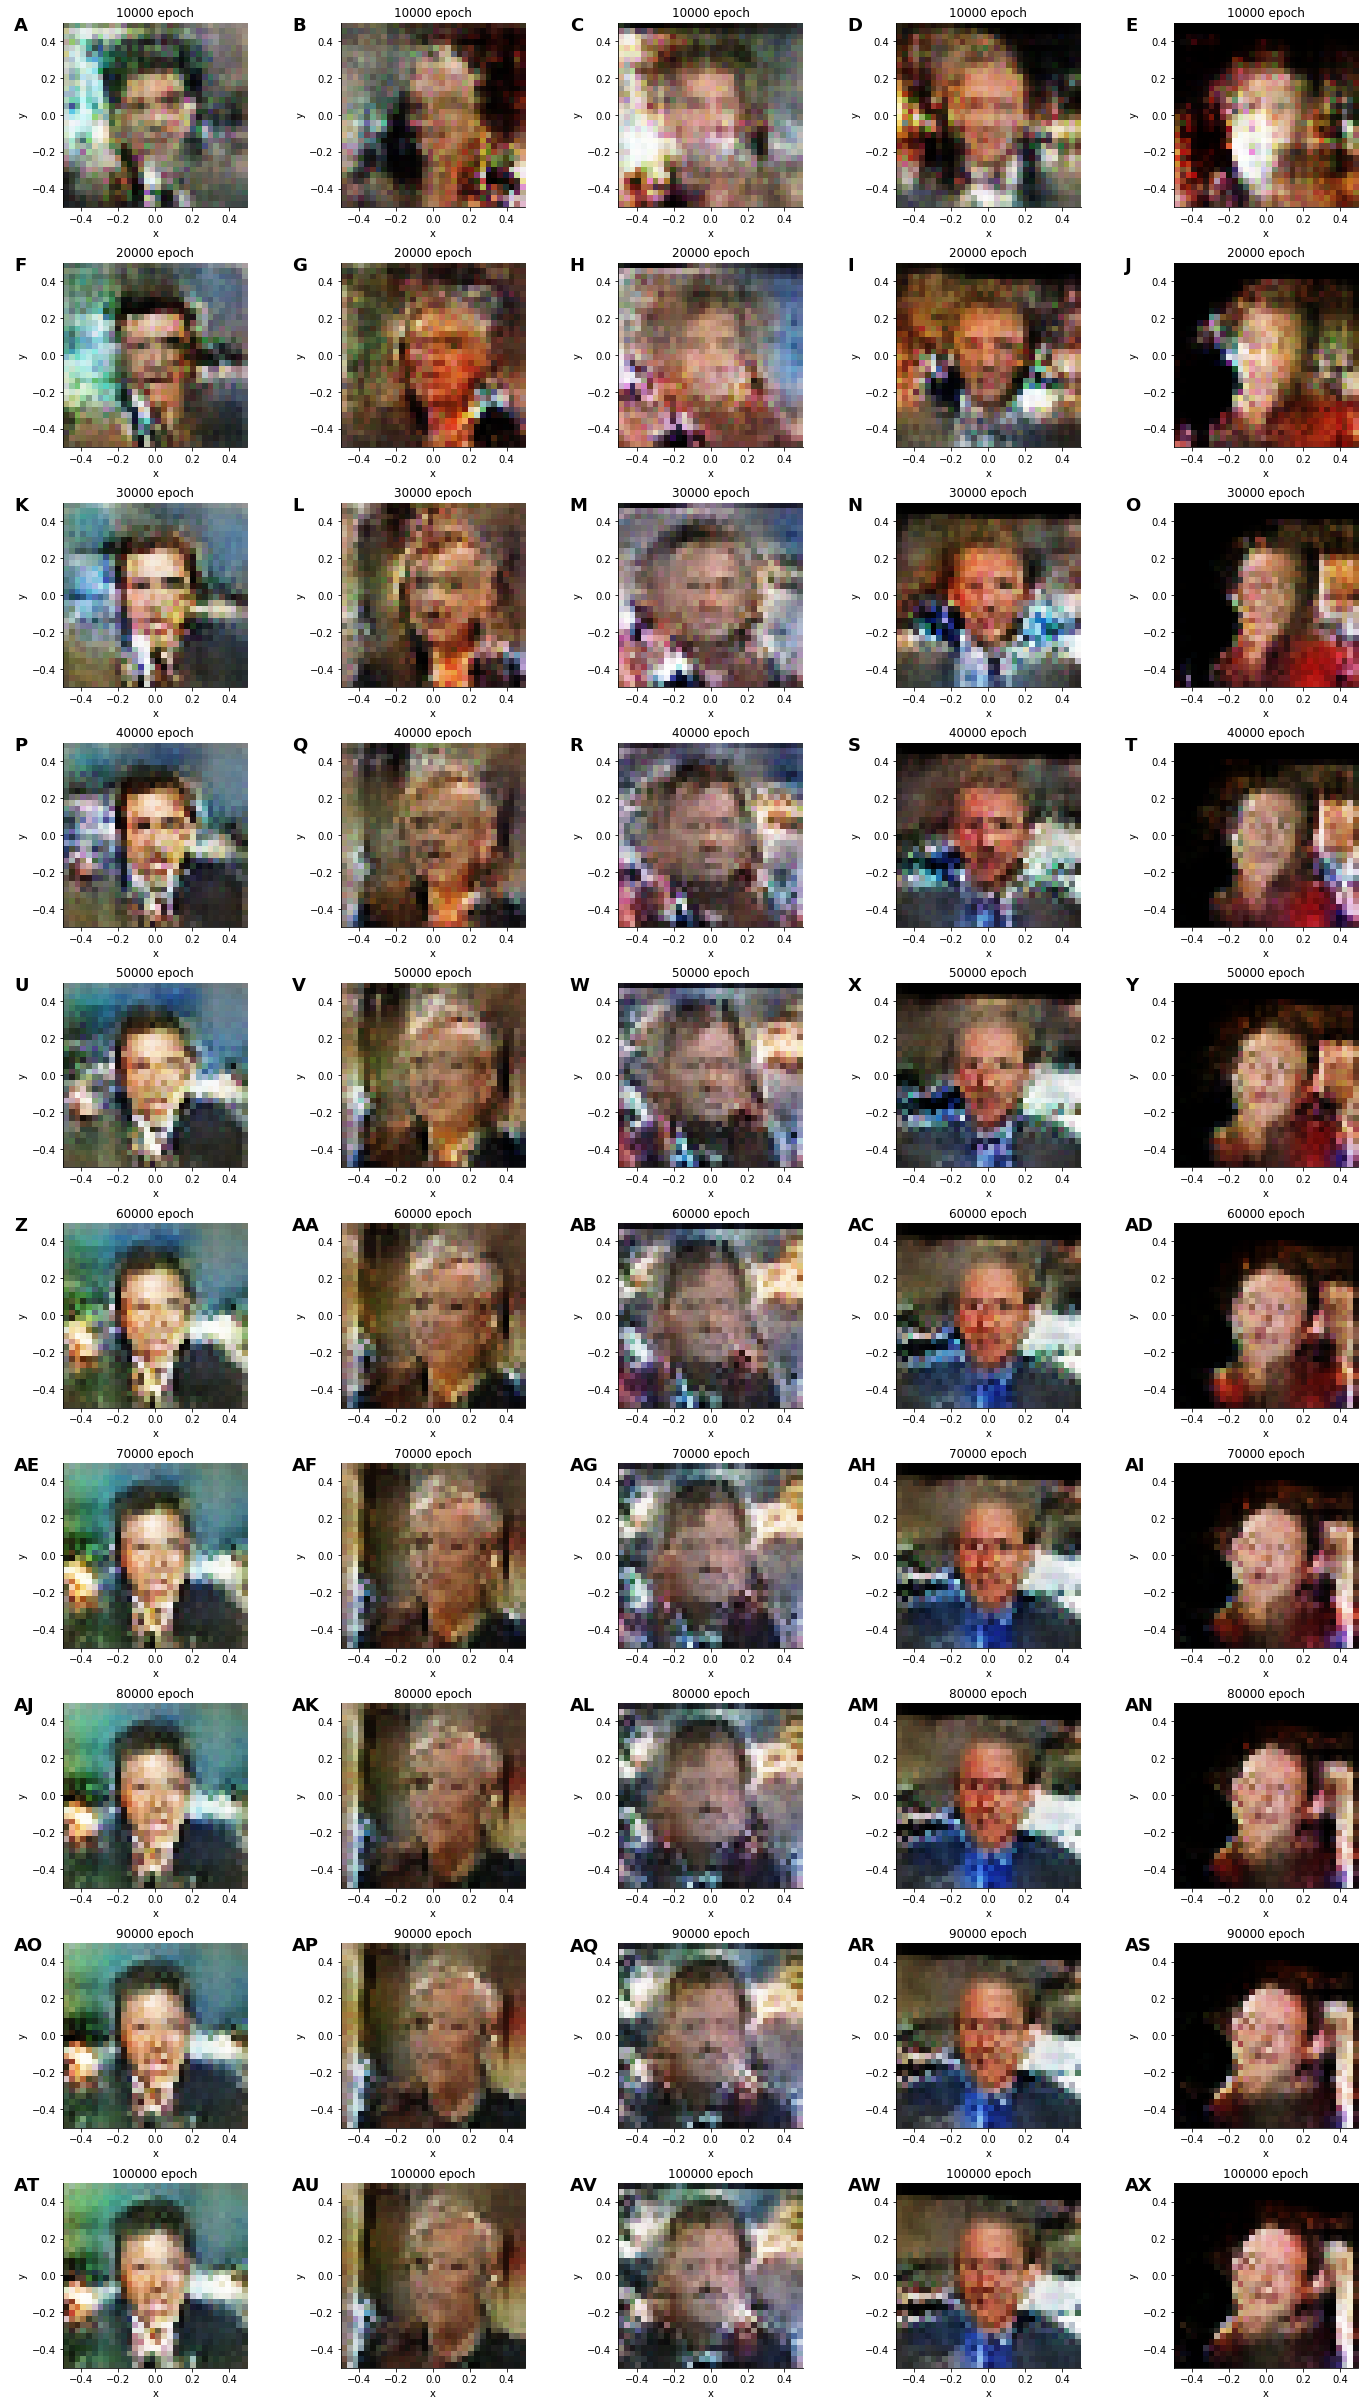

In [5]:
import holoviews as hv
hv.notebook_extension()
for j in range(1, 11):
    y = np_samples[j]
    for i in range(5):
        if j == 1 and i == 0:
            hv_points = hv.RGB(y[i]).relabel(str(j*10000)+' epoch')
        else:
            hv_points += hv.RGB(y[i]).relabel(str(j*10000)+' epoch')
hv_points.cols(5)

:Layout
   .RGB.I       :RGB   [x,y]   (R,G,B)
   .RGB.II      :RGB   [x,y]   (R,G,B)
   .RGB.III     :RGB   [x,y]   (R,G,B)
   .RGB.IV      :RGB   [x,y]   (R,G,B)
   .RGB.V       :RGB   [x,y]   (R,G,B)
   .RGB.VI      :RGB   [x,y]   (R,G,B)
   .RGB.VII     :RGB   [x,y]   (R,G,B)
   .RGB.VIII    :RGB   [x,y]   (R,G,B)
   .RGB.IX      :RGB   [x,y]   (R,G,B)
   .RGB.X       :RGB   [x,y]   (R,G,B)
   .RGB.XI      :RGB   [x,y]   (R,G,B)
   .RGB.XII     :RGB   [x,y]   (R,G,B)
   .RGB.XIII    :RGB   [x,y]   (R,G,B)
   .RGB.XIV     :RGB   [x,y]   (R,G,B)
   .RGB.XV      :RGB   [x,y]   (R,G,B)
   .RGB.XVI     :RGB   [x,y]   (R,G,B)
   .RGB.XVII    :RGB   [x,y]   (R,G,B)
   .RGB.XVIII   :RGB   [x,y]   (R,G,B)
   .RGB.XIX     :RGB   [x,y]   (R,G,B)
   .RGB.XX      :RGB   [x,y]   (R,G,B)
   .RGB.XXI     :RGB   [x,y]   (R,G,B)
   .RGB.XXII    :RGB   [x,y]   (R,G,B)
   .RGB.XXIII   :RGB   [x,y]   (R,G,B)
   .RGB.XXIV    :RGB   [x,y]   (R,G,B)
   .RGB.XXV     :RGB   [x,y]   (R,G,B)
   .RGB.XXVI    :RGB   [x,y]   (R,G,B)
   .RGB.XXVII   :RGB   [x,y]   (R,G,B)
   .RGB.XXVIII  :RGB   [x,y]   (R,G,B)
   .RGB.XXIX    :RGB   [x,y]   (R,G,B)
   .RGB.XXX     :RGB   [x,y]   (R,G,B)
   .RGB.XXXI    :RGB   [x,y]   (R,G,B)
   .RGB.XXXII   :RGB   [x,y]   (R,G,B)
   .RGB.XXXIII  :RGB   [x,y]   (R,G,B)
   .RGB.XXXIV   :RGB   [x,y]   (R,G,B)
   .RGB.XXXV    :RGB   [x,y]   (R,G,B)
   .RGB.XXXVI   :RGB   [x,y]   (R,G,B)
   .RGB.XXXVII  :RGB   [x,y]   (R,G,B)
   .RGB.XXXVIII :RGB   [x,y]   (R,G,B)
   .RGB.XXXIX   :RGB   [x,y]   (R,G,B)
   .RGB.XL      :RGB   [x,y]   (R,G,B)
   .RGB.XLI     :RGB   [x,y]   (R,G,B)
   .RGB.XLII    :RGB   [x,y]   (R,G,B)
   .RGB.XLIII   :RGB   [x,y]   (R,G,B)
   .RGB.XLIV    :RGB   [x,y]   (R,G,B)
   .RGB.XLV     :RGB   [x,y]   (R,G,B)
   .RGB.XLVI    :RGB   [x,y]   (R,G,B)
   .RGB.XLVII   :RGB   [x,y]   (R,G,B)
   .RGB.XLVIII  :RGB   [x,y]   (R,G,B)
   .RGB.XLIX    :RGB   [x,y]   (R,G,B)
   .RGB.L       :RGB   [x,y]   (R,G,B)
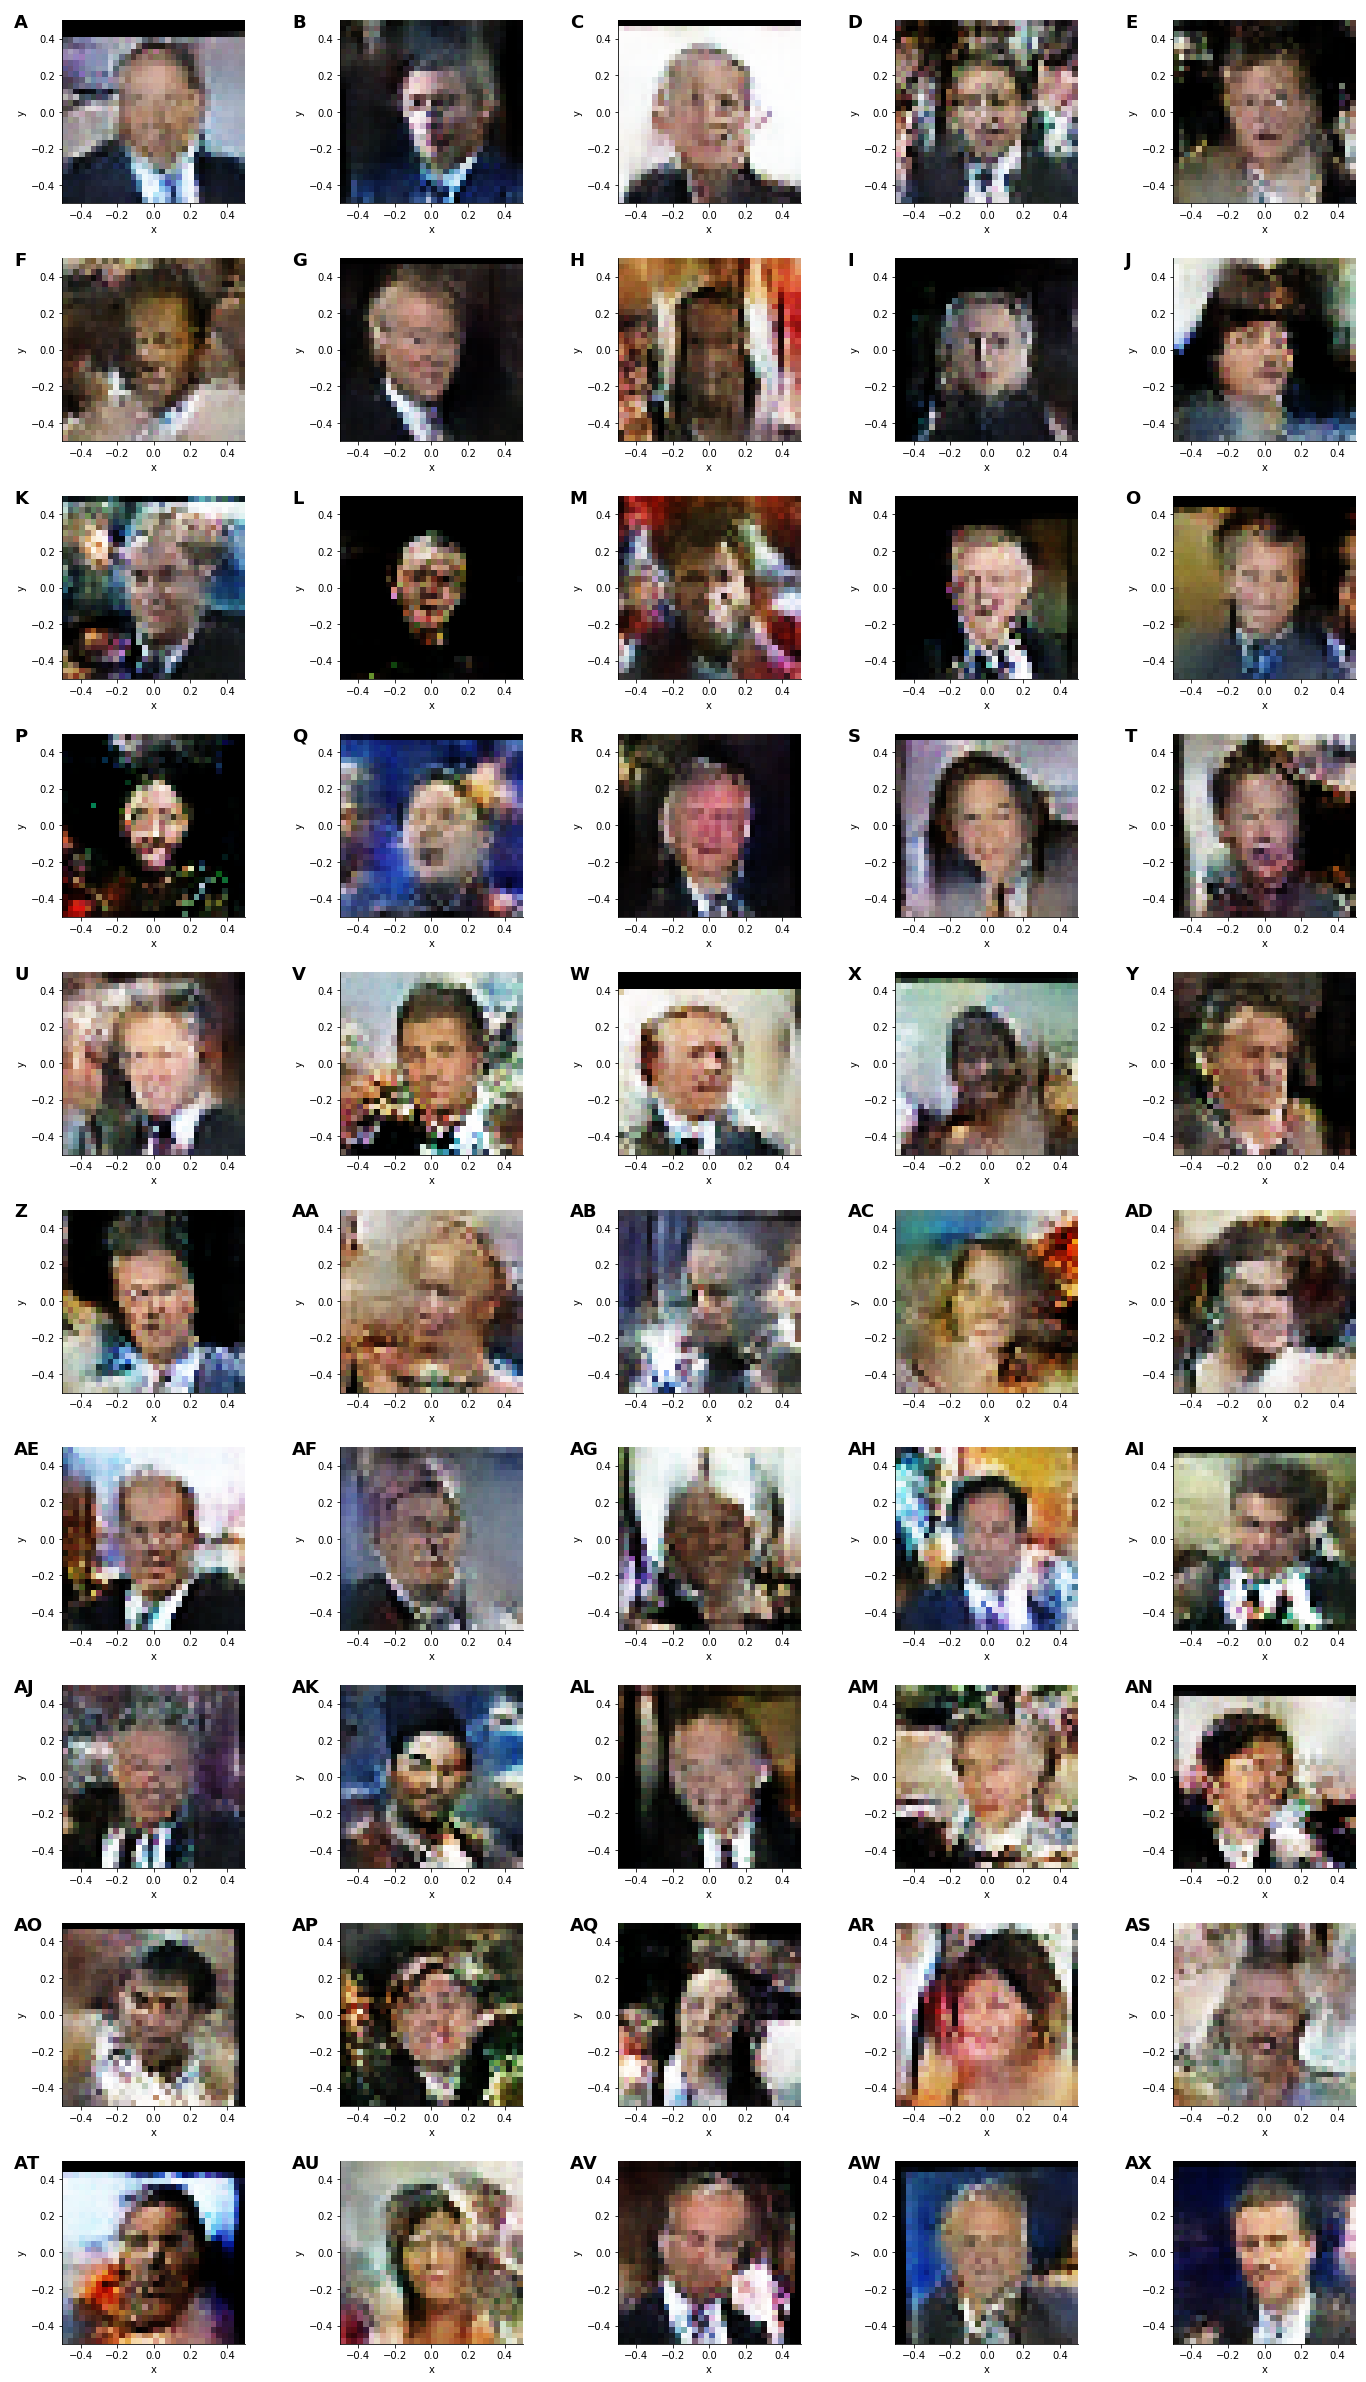

In [7]:
noise = np.random.normal(0, 1, (50, gan.latent_dim))
gen_imgs = gan.generator.predict(noise)
y = ((0.5 * gen_imgs + 0.5) * 255).astype(np.uint8)
for j in range(50):
    if j == 0:
        hv_points = hv.RGB(y[j])
    else:
        hv_points += hv.RGB(y[j])
hv_points.cols(5)